# Neural Networks retrieval on the Satellite Observations Dataset

In this final step we develop a model to estimate soil moisture using neural networks

Libraries we need are imported first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import xarray as xr
from scipy.interpolate import griddata
from scipy import interpolate
import statsmodels.api as sm

import torch
from torch import nn, optim
from torch.optim import SGD

# from torch.optim import RMSprop
# from torch.utils.data import TensorDataset
# from torchmetrics import (MeanAbsoluteError, R2Score)
# # from torchinfo import summary
# from torchvision.io import read_image
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import CSVLogger

Data used in this exercise is stored in the DATA folder

In [3]:
thefile = '../../../DATA/TPdata_199301'
orig_data = pd.read_csv(thefile, sep='\t', header=None)
orig_data.columns = ["cellNr", "latitude", "longitude", "backscatter","emissivity_v","emissivity_h","ts_amplitude","ndvi","lmd_soilWetness"]
orig_data = orig_data.replace('   NaN',pd.NA)
data = orig_data.iloc[::5,:]
test_data = orig_data.iloc[1::5,:]
data['backscatter'] = pd.to_numeric(data['backscatter'])
data['emissivity_v'] = pd.to_numeric(data['emissivity_v'])
data['emissivity_h'] = pd.to_numeric(data['emissivity_h'])
data['ts_amplitude'] = pd.to_numeric(data['ts_amplitude'])
data['ndvi'] = pd.to_numeric(data['ndvi'])
data['lmd_soilWetness'] = pd.to_numeric(data['lmd_soilWetness'])
data = data.dropna()
test_data = test_data.dropna()
data = data.iloc[0:len(test_data),:]

/var/folders/42/4grwdj956wxfq8phsmjtnjdm0000gn/T/ipykernel_23941/14476055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['backscatter'] = pd.to_numeric(data['backscatter'])
/var/folders/42/4grwdj956wxfq8phsmjtnjdm0000gn/T/ipykernel_23941/14476055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emissivity_v'] = pd.to_numeric(data['emissivity_v'])
/var/folders/42/4grwdj956wxfq8phsmjtnjdm0000gn/T/ipykernel_23941/14476055.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [4]:
len(data)

8895

In [8]:
len(test_data)

8895

In [10]:
thres = len(data)

In [12]:
back = data['backscatter'].values[0:thres]
lats = data['latitude'].values[0:thres]
lons = data['longitude'].values[0:thres]
emissivity_v = data['emissivity_v'].values[0:thres]
emissivity_h = data['emissivity_h'].values[0:thres]
ts_amplitude = data['ts_amplitude'].values[0:thres]
ndvi = data['ndvi'].values[0:thres]
lmd_soilWetness = data['lmd_soilWetness'].values[0:thres]

## Neural Network

In [15]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5,thres)  
        # self.tanh = nn.Tanh()  
        self.fc2 = nn.Linear(thres,1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))  
        x = self.fc2(x)               
        return x

In [17]:
alles = np.stack((back,emissivity_v,emissivity_h,ts_amplitude,ndvi),axis=1)
# alles = np.stack((back,ts_amplitude,ndvi),axis=1)
# alles = np.stack((ts_amplitude),axis=1)

In [19]:
X_train = torch.tensor(alles).to(torch.float32)
y_train = torch.tensor(lmd_soilWetness).to(torch.float32)

In [21]:
# y_train = y_train[...,None]
y_train.size()

torch.Size([8895])

In [23]:
X_train

tensor([[-11.7482,   0.8083,   0.6605,  22.8432,   0.4072],
        [-11.6666,   0.8497,   0.7343,  24.4724,   0.1540],
        [-15.3758,   0.9881,   0.9418,  33.5860,   0.2251],
        ...,
        [-11.0103,   0.9789,   0.9658,  11.9511,   0.4320],
        [-11.0627,   0.9737,   0.9556,  10.9862,   0.4364],
        [-15.8875,   0.9960,   0.9439,  23.0279,   0.1905]])

In [25]:
y_train

tensor([0.4771, 0.5946, 0.2152,  ..., 0.8250, 0.7062, 0.1987])

In [27]:
model = SimpleNN()  
criterion = nn.MSELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [29]:
for epoch in range(100):  
    model.train() 

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  
    
    # Backward pass and optimize
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()  

    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/100], Loss: {loss.item():.4f}')

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8895])) that is different to the input size (torch.Size([8895, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 222627676160.0000
Epoch [20/100], Loss: 2566721536.0000
Epoch [30/100], Loss: 29592278.0000
Epoch [40/100], Loss: 341175.6250
Epoch [50/100], Loss: 3933.5405
Epoch [60/100], Loss: 45.4053
Epoch [70/100], Loss: 0.5781
Epoch [80/100], Loss: 0.0613
Epoch [90/100], Loss: 0.0554
Epoch [100/100], Loss: 0.0553


## Performance of the Neural Network

In [32]:
test_data['backscatter'] = pd.to_numeric(test_data['backscatter'])
test_data['emissivity_v'] = pd.to_numeric(test_data['emissivity_v'])
test_data['emissivity_h'] = pd.to_numeric(test_data['emissivity_h'])
test_data['ts_amplitude'] = pd.to_numeric(test_data['ts_amplitude'])
test_data['ndvi'] = pd.to_numeric(test_data['ndvi'])
test_data['lmd_soilWetness'] = pd.to_numeric(test_data['lmd_soilWetness'])

In [34]:
test_back = test_data['backscatter'].values[0:thres]
test_lats = test_data['latitude'].values[0:thres]
test_lons = test_data['longitude'].values[0:thres]
test_emissivity_v = test_data['emissivity_v'].values[0:thres]
test_emissivity_h = test_data['emissivity_h'].values[0:thres]
test_ts_amplitude = test_data['ts_amplitude'].values[0:thres]
test_ndvi = test_data['ndvi'].values[0:thres]
test_lmd_soilWetness = test_data['lmd_soilWetness'].values[0:thres]

In [36]:
test_alles = np.stack((test_back,test_emissivity_v,test_emissivity_h,test_ts_amplitude,test_ndvi),axis=1)

In [38]:
model.eval()  
with torch.no_grad(): 
    testing_data = torch.tensor(test_alles).to(torch.float32)
    predictions = model(testing_data) 
    print(f'Predictions:\n{predictions}')

Predictions:
tensor([[0.4962],
        [0.4962],
        [0.4962],
        ...,
        [0.4962],
        [0.4962],
        [0.4962]])


In [40]:
len(predictions)

8895

In [42]:
output = predictions.detach().cpu().numpy()

In [44]:
output

array([[0.49616045],
       [0.49616045],
       [0.49616045],
       ...,
       [0.49616045],
       [0.49616045],
       [0.49616045]], dtype=float32)

In [46]:
np.mean(output)

0.5013174

In [48]:
test_data['NN']=output

In [137]:
test_data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness,NN
74276,74277.0,-50.875,-73.0693,-11.4033,0.9364,0.8869,30.1807,0.3415,0.5781,0.496302
74281,74282.0,-50.875,-71.0891,-14.6431,0.9981,0.9542,32.4869,0.2000,0.2076,0.496302
76111,76112.0,-50.375,-71.1765,-14.3510,0.9829,0.9368,37.5393,0.1720,0.2062,0.496302
77956,77957.0,-49.875,-72.7371,-13.7268,0.8999,0.8123,35.4797,0.1320,0.4314,0.496302
79831,79832.0,-49.375,-70.4264,-14.4097,0.9796,0.9214,42.6025,0.1312,0.2093,0.496302
...,...,...,...,...,...,...,...,...,...,...
589236,589237.0,51.875,9.5163,-8.9858,0.9642,0.9250,6.8976,0.1731,0.8494,0.496302
590096,590097.0,51.875,-2.2272,-8.9367,0.9529,0.9077,5.4218,0.4087,0.8407,0.496302
591006,591007.0,52.375,8.3959,-9.7867,0.9619,0.9122,12.1349,0.1273,0.6934,0.496302
593601,593602.0,52.875,-2.6928,-9.3162,0.9663,0.9267,4.3450,0.4691,0.8262,0.496302


In [139]:
# lats = test_data['latitude'].values[0:thres]
# lons = test_data['longitude'].values[0:thres]
# Yi = np.linspace(np.min(lats.data),float(np.max(lats.data)),180)
# Xi = np.linspace(np.min(lons.data),float(np.max(lons.data)),360)
# X, Y = np.meshgrid(Xi,Yi)
# points = list(zip(lons, lats))
# test_SM = griddata(points, output, (X, Y), method='nearest')

(-90.0, 90.0)

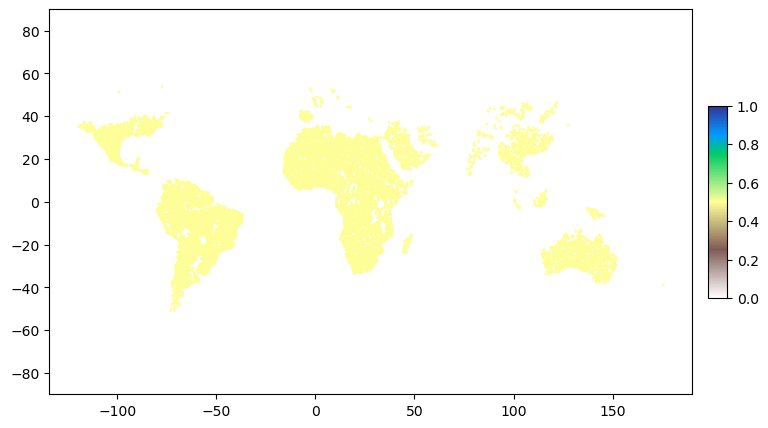

In [141]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.scatter(test_data['longitude'],test_data['latitude'],c=test_data['NN'],s=1, cmap='terrain_r', vmin=0, vmax=1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
ax.set_ylim(-90,90)